In [1]:
import json
from collections import defaultdict
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse

from matplotlib.patches import Rectangle
import statsmodels.api as sm


//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/ssc/ssc.ped'
chroms = [str(x) for x in range(1, 23)]

In [3]:
colors=['#ef6c00', '#4db6ac']

In [4]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [5]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                child_id = ssc_old_id_to_new_id[child_id]
                f_id = ssc_old_id_to_new_id[f_id]
                m_id = ssc_old_id_to_new_id[m_id]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 1037


# pull our deletions

In [6]:
# pull deletions
deletions = []
with open('../phased_ssc_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                deletions.append({
                                'family': d['family'],
                                'child': ssc_old_id_to_new_id[child],
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': ssc_old_id_to_new_id[d['mother']],
                                'father': ssc_old_id_to_new_id[d['father']],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers': d['num_markers']
                        })
print(len(deletions))

162754


In [7]:
#inds = fam_to_inds[(family_id, 'SSC03078', 'SSC03092')]
#inds = fam_to_inds[(family_id, 'SSC03078', 'SSC03092')]
#print(inds)

with open('../phased_ssc_del/individuals.json') as f:
    individuals = set([ssc_old_id_to_new_id[x] for x in json.load(f)])
print(len(individuals))

our_families = set([fam_id[0] for (fam_id, inds) in fam_to_inds.items() if np.all([x in individuals for x in inds])])
print(len(our_families))

2071
518


# pull sebat deletions

In [8]:
# pull deletions
sebat_deletions = []
with open('../phased_ssc.sebat_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                sebat_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers_ssc': d['num_markers_ssc']
                        })
print(len(sebat_deletions))

1420888


In [9]:
with open('../phased_ssc.sebat_del/families.json') as f:
    sebat_families = set(json.load(f))
print(len(sebat_families))

517


In [10]:
print(len([x for x in sebat_deletions if not x['is_mat'] and not x['is_pat']])/len(sebat_deletions))

0.0


In [11]:
print(list(our_families)[:5], list(sebat_families)[:5])

['14629', '12795', '11990', '11474', '12574'] ['14629', '12795', '11990', '11474', '12574']


# Remove deletions if family isn't in both datasets

In [12]:
both_families = our_families & set(sebat_families)
print(len(both_families))

print(len(deletions), len(sebat_deletions))

deletions = [d for d in deletions if d['family'] in both_families]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['family'] in both_families]
print('remaining deletions', len(sebat_deletions))


516
162754 1420888
remaining deletions 162280
remaining deletions 1416733


# Remove deletions in certain regions, that are <100bp, that aren't inherited

In [13]:
#remove deletions that aren't inherited
deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['is_inherited']]
print('remaining deletions', len(sebat_deletions))

remaining deletions 162280
remaining deletions 1416733


In [14]:
#remove deletions <100bp
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['length']>=100]
print('remaining deletions', len(sebat_deletions))

remaining deletions 136346
remaining deletions 1416733


In [16]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
deletions = [d for i, d in enumerate(deletions) if i not in excluded_deletions]
print('remaining deletions', len(deletions))

excluded_deletions = set()
for i, d in enumerate(sebat_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
sebat_deletions = [d for i, d in enumerate(sebat_deletions) if i not in excluded_deletions]
print('remaining deletions', len(sebat_deletions))

excluded deletions 58766
remaining deletions 77580
excluded deletions 47558
remaining deletions 1369175


# look at overlap between our deletions and sebat deletions

In [17]:
print(len(deletions))
print(len(sebat_deletions))

77580
1369175


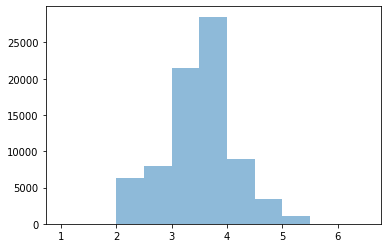

In [18]:
plt.hist(np.log10([x['length'] for x in deletions]), alpha=0.5, bins=np.arange(1, 7, 0.5))
#plt.hist(np.log10([x['length'] for x in sebat_deletions]), alpha=0.5, bins=np.arange(1, 7, 0.5))
plt.show()

In [19]:

chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(deletions):
    chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
sebat_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(sebat_deletions):
    sebat_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))

del_to_overlaps = defaultdict(list)
sebat_del_to_overlaps = defaultdict(list)
for (fam, chrom), ds in chrom_fam_to_dels.items():
    sds = sebat_chrom_fam_to_dels[(fam, chrom)]

    for i, d in ds:
        d_start, d_end = d['start_pos'], d['end_pos']
        for j, sb in sds:
            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']) and ((d['is_mat'] and sb['is_mat']) or (d['is_pat'] and sb['is_pat'])):
                overlap = min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']) 

                if overlap>0:
                    del_to_overlaps[i].append(j)
                    sebat_del_to_overlaps[j].append(i)


        
        

In [20]:
is_val = np.zeros((len(deletions),), dtype=bool)
for del_index, overlap_indices in list(del_to_overlaps.items()):
    start_pos = deletions[del_index]['start_pos']
    length = deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, sebat_deletions[overlap_index]['start_pos']-start_pos):min(length, sebat_deletions[overlap_index]['end_pos']-start_pos)] = True
    if np.sum(d)>0.5*length:
        is_val[del_index] = True
print(np.sum(is_val)/len(deletions))

sebat_is_val = np.zeros((len(sebat_deletions),), dtype=bool)
for del_index, overlap_indices in list(sebat_del_to_overlaps.items()):
    start_pos = sebat_deletions[del_index]['start_pos']
    length = sebat_deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, deletions[overlap_index]['start_pos']-start_pos):min(length, deletions[overlap_index]['end_pos']-start_pos)] = True
    if np.sum(d)>0.5*length:
        sebat_is_val[del_index] = True
print(np.sum(sebat_is_val)/len(sebat_deletions))

0.7738721319927816
0.03971661767122537


In [21]:
del_lengths = np.array([x['length'] for x in deletions])
sebat_del_lengths = np.array([x['length'] for x in sebat_deletions])
print(np.sum(is_val[del_lengths>100])/np.sum(del_lengths>100),
      np.sum(sebat_is_val[sebat_del_lengths>100])/np.sum(sebat_del_lengths>100))
print(np.sum(is_val[del_lengths>1000])/np.sum(del_lengths>1000),
      np.sum(sebat_is_val[sebat_del_lengths>1000])/np.sum(sebat_del_lengths>1000))
print(np.sum(is_val[del_lengths>10000])/np.sum(del_lengths>10000),
      np.sum(sebat_is_val[sebat_del_lengths>10000])/np.sum(sebat_del_lengths>10000))
print(np.sum(is_val[del_lengths>100000])/np.sum(del_lengths>100000),
      np.sum(sebat_is_val[sebat_del_lengths>100000])/np.sum(sebat_del_lengths>100000))
print(np.sum(is_val[del_lengths>1000000])/np.sum(del_lengths>1000000),
      np.sum(sebat_is_val[sebat_del_lengths>1000000])/np.sum(sebat_del_lengths>1000000))

0.7740500535090321 0.039955033229121126
0.8493137718883105 0.09480802069298441
0.9015485898107279 0.21041510462817803
0.935361216730038 0.5598469032707029
1.0 1.0


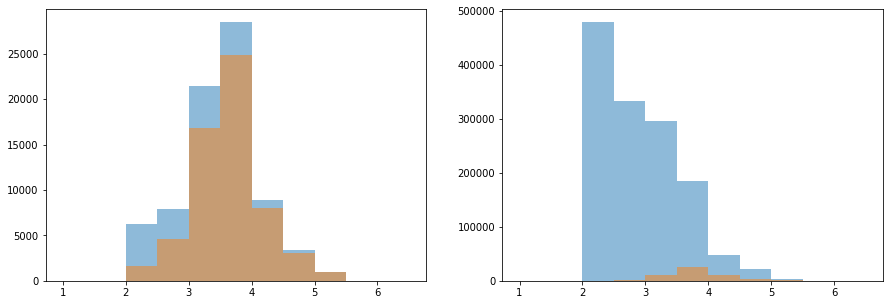

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ours_n, _, _ = plt.hist(np.log10(del_lengths), alpha=0.5, bins=np.arange(1, 7, 0.5))
val_n, _, _ = plt.hist(np.log10(del_lengths[is_val]), alpha=0.5, bins=np.arange(1, 7, 0.5))

plt.subplot(1, 2, 2)
sebat_n, _, _ = plt.hist(np.log10(sebat_del_lengths), alpha=0.5, bins=np.arange(1, 7, 0.5))
sebat_val_n, _, _ = plt.hist(np.log10(sebat_del_lengths[sebat_is_val]), alpha=0.5, bins=np.arange(1, 7, 0.5))

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


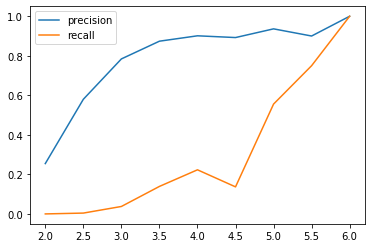

In [23]:
plt.plot(np.arange(1, 6.5, 0.5), val_n/ours_n, label='precision')
plt.plot(np.arange(1, 6.5, 0.5), sebat_val_n/sebat_n, label='recall')
plt.legend()
plt.show()

In [24]:
num_markers_ssc = np.array([d['num_markers'] for d in deletions])
num_markers_sebat = np.array([d['num_markers_ssc'] for d in sebat_deletions])


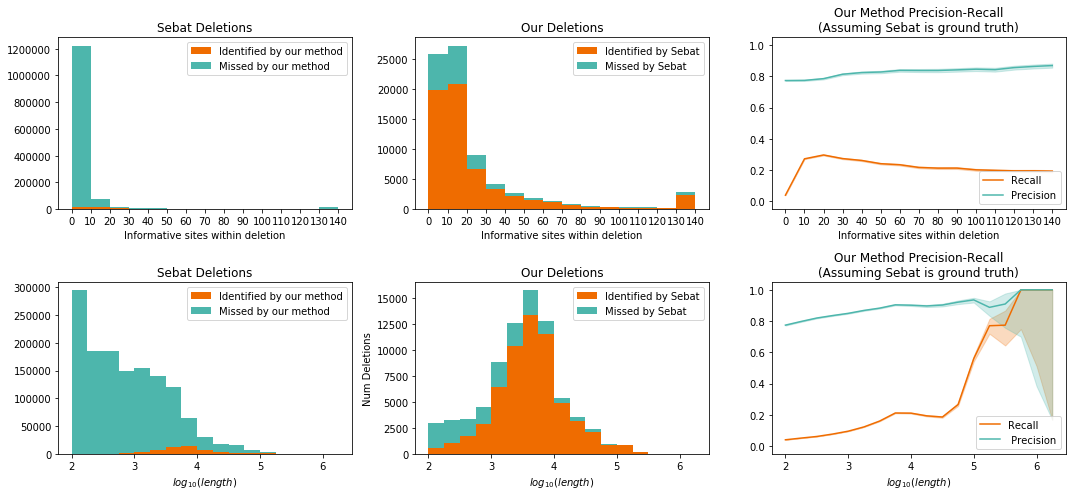

In [25]:
bins = np.arange(0, 150, 10)
plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 3, 1)
plt.hist([np.clip(num_markers_sebat[sebat_is_val], 0, bins[-2]), np.clip(num_markers_sebat[~sebat_is_val], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Sebat Deletions')
plt.xticks(bins)

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by our method","Missed by our method"]
plt.legend(handles, labels)

plt.subplot(2, 3, 2, sharex=ax)
plt.hist([np.clip(num_markers_ssc[is_val], 0, bins[-2]), np.clip(num_markers_ssc[~is_val], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by Sebat","Missed by Sebat"]
plt.legend(handles, labels)

plt.subplot(2, 3, 3, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
percent_val_ssc_ub, percent_val_ssc_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
for i, j in enumerate(bins):
    x = np.sum((num_markers_sebat>=j) & sebat_is_val)
    n = np.sum((num_markers_sebat>=j))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    
    
    x = np.sum((num_markers_ssc>=j) & is_val)
    n = np.sum(num_markers_ssc>=j)
    percent_val_ssc[i] = x/n
    percent_val_ssc_ub[i], percent_val_ssc_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    
    
plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val_ssc, label='Precision', color=colors[1])
plt.fill_between(bins, percent_val_ssc_ub, percent_val_ssc_lb, color=colors[1], alpha=0.25)
plt.xlabel('Informative sites within deletion')
#plt.ylabel('Fraction of Deletions Validated')
plt.legend()
plt.title('Our Method Precision-Recall\n(Assuming Sebat is ground truth)')
plt.ylim([-0.05, 1.05])


bins = np.arange(2, 6.5, 0.25)
ax = plt.subplot(2, 3, 4)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(sebat_del_lengths)[sebat_is_val], 0, 6), np.clip(np.log10(sebat_del_lengths)[~sebat_is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.title('Sebat Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by our method","Missed by our method"]
plt.legend(handles, labels)

plt.subplot(2, 3, 5, sharex=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(del_lengths)[is_val], 0, 6), np.clip(np.log10(del_lengths)[~is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.ylabel('Num Deletions')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by Sebat","Missed by Sebat"]
plt.legend(handles, labels)

plt.subplot(2, 3, 6, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
percent_val_ssc_ub, percent_val_ssc_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
for i, j in enumerate(bins):
    x = np.sum((np.log10(sebat_del_lengths)>=j) & sebat_is_val)
    n = np.sum((np.log10(sebat_del_lengths)>=j))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    

    x = np.sum((np.log10(del_lengths)>=j) & is_val)
    n = np.sum(np.log10(del_lengths)>=j)
    percent_val_ssc[i] = x/n
    percent_val_ssc_ub[i], percent_val_ssc_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    

plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val_ssc, label=' Precision', color=colors[1])
plt.fill_between(bins, percent_val_ssc_ub, percent_val_ssc_lb, color=colors[1], alpha=0.25)
plt.xlabel('$log_{10}(length)$')
plt.legend()
plt.title('Our Method Precision-Recall\n(Assuming Sebat is ground truth)')
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


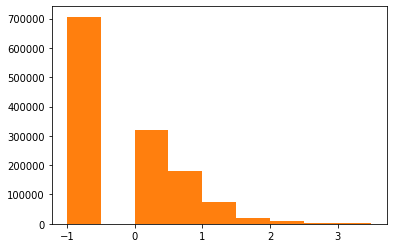

In [26]:
plt.hist(np.clip(np.log10(num_markers_sebat[sebat_is_val]), -1, None), bins=np.arange(-1, 4, 0.5))
plt.hist(np.clip(np.log10(num_markers_sebat[~sebat_is_val]), -1, None), bins=np.arange(-1, 4, 0.5))
plt.show()

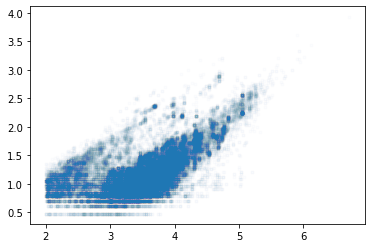

In [27]:
plt.scatter(np.log10(del_lengths), np.log10(num_markers_ssc), alpha=0.01, marker='.')
plt.show()

In [28]:
bins=np.arange(1, 6, 0.5)

num_aut_trans, num_nt_trans = np.zeros((len(bins), 2), dtype=int), np.zeros((len(bins), 2), dtype=int)
for d in deletions:
    if child_id_to_affected[d['child']]=='2':
        num_aut_trans[np.digitize(np.log10(d['length']), bins[:-1]), int(d['is_mat'])] += 1
    elif child_id_to_affected[d['child']]=='1':
        num_nt_trans[np.digitize(np.log10(d['length']), bins[:-1]), int(d['is_mat'])] += 1
    else:
        print(child_id_to_affected[d['child']])
        
sebat_num_aut_trans, sebat_num_nt_trans, sebat_num_both_trans = np.zeros((len(bins),2), dtype=int), np.zeros((len(bins), 2), dtype=int), np.zeros((len(bins), 2), dtype=int)
for d in sebat_deletions:
    if (d['is_mat'] and not d['is_pat']) or (d['is_pat'] and not d['is_mat']):
        if child_id_to_affected[d['child']]=='2':
            sebat_num_aut_trans[np.digitize(np.log10(d['length']), bins[:-1]), int(d['is_mat'])] += 1
        elif child_id_to_affected[d['child']]=='1':
            sebat_num_nt_trans[np.digitize(np.log10(d['length']), bins[:-1]), int(d['is_mat'])] += 1
        else:
            print(child_id_to_affected[d['child']])



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


pat [1.0, 1.0, 1.0, 0.5728184821728174, 0.3494375928229005, 0.8478146863644085, 0.3766090352132798, 0.12147632122010774, 0.8086495343453524, 0.7234524125363876]
pat [1.0, 1.0, 1.0, 0.2554424916924379, 0.29954301000460687, 0.8944201898487804, 0.982920889901113, 0.41070709431267327, 0.9714984002776335, 0.7857482982746367]
mat [1.0, 1.0, 1.0, 0.3984227715700802, 0.9999999999960169, 0.9304201342188609, 0.8930668854569666, 0.7209050645969577, 0.26073936752584825, 0.7964663711393225]
mat [1.0, 1.0, 1.0, 0.9582795254924975, 0.715246859204166, 0.6739748980106797, 0.616609733347457, 0.5463645235392672, 0.8744973688391626, 0.8140718309634558]
[1.0, 1.0, 1.0, 0.31168802500417503, 0.5149778677919391, 0.9456081393714618, 0.4665662273347715, 0.4093246955512478, 0.3267312976419623, 0.6437651301927669]
[1.0, 1.0, 1.0, 0.3985190570467233, 0.6353216621048255, 0.8401870750956151, 0.7104214763677557, 0.3111180418148255, 0.88503689651146, 1.0]


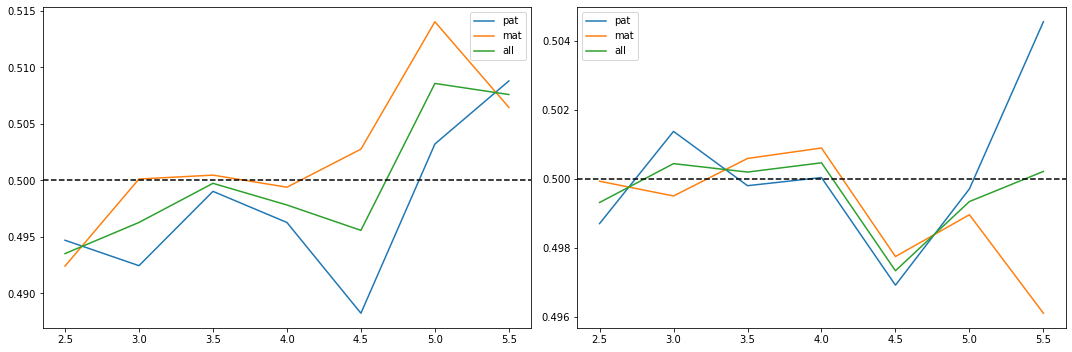

In [29]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.plot(bins, num_aut_trans[:, 0]/(num_aut_trans[:, 0]+num_nt_trans[:, 0]), label='pat')
plt.plot(bins, num_aut_trans[:, 1]/(num_aut_trans[:, 1]+num_nt_trans[:, 1]), label='mat')
plt.plot(bins, np.sum(num_aut_trans, axis=1)/(np.sum(num_aut_trans, axis=1)+np.sum(num_nt_trans, axis=1)), label='all')
plt.axhline(0.5, color='black', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bins, sebat_num_aut_trans[:, 0]/(sebat_num_aut_trans[:, 0]+sebat_num_nt_trans[:, 0]), label='pat')
plt.plot(bins, sebat_num_aut_trans[:, 1]/(sebat_num_aut_trans[:, 1]+sebat_num_nt_trans[:, 1]), label='mat')
plt.plot(bins, np.sum(sebat_num_aut_trans, axis=1)/(np.sum(sebat_num_aut_trans, axis=1)+np.sum(sebat_num_nt_trans, axis=1)), label='all')
plt.axhline(0.5, color='black', linestyle='--')
plt.legend()

print('pat', [stats.binom_test(num_aut_trans[i, 0], num_aut_trans[i, 0]+num_nt_trans[i, 0]) for i in range(len(bins))])
print('pat', [stats.binom_test(sebat_num_aut_trans[i, 0], sebat_num_aut_trans[i, 0]+sebat_num_nt_trans[i, 0]) for i in range(len(bins))])

print('mat', [stats.binom_test(num_aut_trans[i, 1], num_aut_trans[i, 1]+num_nt_trans[i, 1]) for i in range(len(bins))])
print('mat', [stats.binom_test(sebat_num_aut_trans[i, 1], sebat_num_aut_trans[i, 1]+sebat_num_nt_trans[i, 1]) for i in range(len(bins))])

print([stats.binom_test(np.sum(num_aut_trans[i, :]), np.sum(num_aut_trans[i, :])+np.sum(num_nt_trans[i, :])) for i in range(len(bins))])
print([stats.binom_test(np.sum(sebat_num_aut_trans[i, :]), np.sum(sebat_num_aut_trans[i, :])+np.sum(sebat_num_nt_trans[i, :])) for i in range(len(bins))])

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


aut [1.0, 1.0, 1.0, 0.08722793847350375, 0.7378993280714673, 0.32493337708659, 0.6325103351333561, 0.10461677254045917, 0.9807529008265533, 0.5737721534754452]
aut [1.0, 1.0, 1.0, 0.22427776730061774, 0.2684337280946803, 0.7626047110717624, 0.6839967332927918, 0.26678227929015125, 0.08742367751608858, 0.5513576213291882]
nt [1.0, 1.0, 1.0, 0.04655320911634269, 0.5478065606257249, 0.19953003042387055, 0.21948215552758754, 0.7771929090501667, 0.41797516462144385, 0.509894554026713]
nt [1.0, 1.0, 1.0, 0.02144028007525692, 0.7675694408048692, 0.8015434418097104, 0.37546998556790184, 0.37289966916737466, 0.11257843691071844, 0.24512621321523753]
all [1.0, 1.0, 1.0, 0.008523645546253648, 0.857454990320209, 0.10738075610938148, 0.22495185174778676, 0.3519238996196842, 0.5937812064732908, 0.3712715969116187]
all [1.0, 1.0, 1.0, 0.01285113846608326, 0.5672467130445701, 0.9729235652466333, 0.35921624208466196, 0.1555721760509854, 0.019336181977995203, 0.20619536851844786]


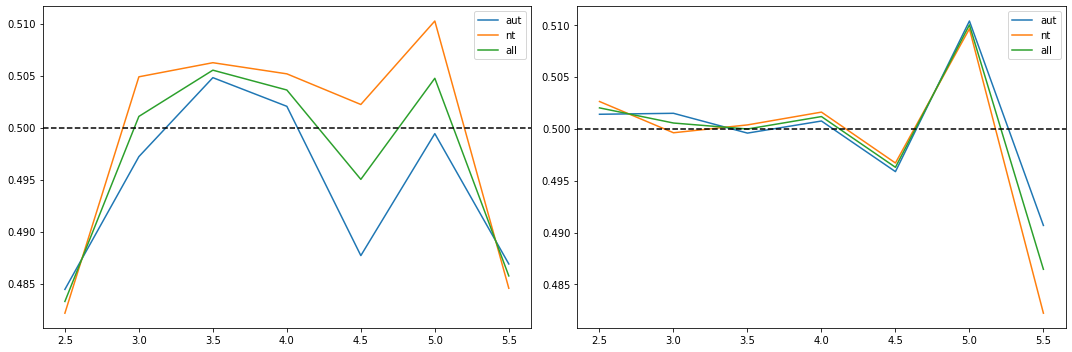

In [30]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.plot(bins, num_aut_trans[:, 0]/(num_aut_trans[:, 0]+num_aut_trans[:, 1]), label='aut')
plt.plot(bins, num_nt_trans[:, 0]/(num_nt_trans[:, 0]+num_nt_trans[:, 1]), label='nt')
plt.plot(bins, (num_aut_trans[:, 0]+num_nt_trans[:, 0])/(num_aut_trans[:, 0]+num_aut_trans[:, 1]+num_nt_trans[:, 0]+num_nt_trans[:, 1]), label='all')
plt.axhline(0.5, color='black', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bins, sebat_num_aut_trans[:, 0]/(sebat_num_aut_trans[:, 0]+sebat_num_aut_trans[:, 1]), label='aut')
plt.plot(bins, sebat_num_nt_trans[:, 0]/(sebat_num_nt_trans[:, 0]+sebat_num_nt_trans[:, 1]), label='nt')
plt.plot(bins, (sebat_num_aut_trans[:, 0]+sebat_num_nt_trans[:, 0])/(sebat_num_aut_trans[:, 0]+sebat_num_aut_trans[:, 1]+sebat_num_nt_trans[:, 0]+sebat_num_nt_trans[:, 1]), label='all')
plt.axhline(0.5, color='black', linestyle='--')
plt.legend()

print('aut', [stats.binom_test(num_aut_trans[i, 0], num_aut_trans[i, 0]+num_aut_trans[i, 1]) for i in range(len(bins))])
print('aut', [stats.binom_test(sebat_num_aut_trans[i, 0], sebat_num_aut_trans[i, 0]+sebat_num_aut_trans[i, 1]) for i in range(len(bins))])

print('nt', [stats.binom_test(num_nt_trans[i, 0], num_nt_trans[i, 0]+num_nt_trans[i, 1]) for i in range(len(bins))])
print('nt', [stats.binom_test(sebat_num_nt_trans[i, 0], sebat_num_nt_trans[i, 0]+sebat_num_nt_trans[i, 1]) for i in range(len(bins))])

print('all', [stats.binom_test(num_aut_trans[i, 0]+num_nt_trans[i, 0], num_aut_trans[i, 0]+num_aut_trans[i, 1]+num_nt_trans[i, 0]+num_nt_trans[i, 1]) for i in range(len(bins))])
print('all', [stats.binom_test(sebat_num_aut_trans[i, 0]+sebat_num_nt_trans[i, 0], sebat_num_aut_trans[i, 0]+sebat_num_aut_trans[i, 1]+sebat_num_nt_trans[i, 0]+sebat_num_nt_trans[i, 1]) for i in range(len(bins))])



plt.tight_layout()
plt.show()

# look at long deletions

In [598]:
print([tuple(a) for a in np.unique([[0, 1, 0], [3, 4, 3]], axis=1)])

[(0, 1), (3, 4)]


In [608]:
print(['%s:%d-%d;%s' % (deletions[i]['chrom'] , deletions[i]['start_pos'], deletions[i]['end_pos'], deletions[i]['family']) for i in np.where(is_val & (del_lengths>10**6))[0]])
print(['%s:%d-%d;%s' % (sebat_deletions[i]['chrom'] , sebat_deletions[i]['start_pos'], sebat_deletions[i]['end_pos'], sebat_deletions[i]['family']) for i in np.where(sebat_is_val & (sebat_del_lengths>10**6))[0]])
print()
print(['%s:%d-%d;%s' % (deletions[i]['chrom'] , deletions[i]['start_pos'], deletions[i]['end_pos'], deletions[i]['family']) for i in np.where(~is_val & (del_lengths>10**6))[0]])
print(['%s:%d-%d;%s' % (sebat_deletions[i]['chrom'] , sebat_deletions[i]['start_pos'], sebat_deletions[i]['end_pos'], sebat_deletions[i]['family']) for i in np.where(~sebat_is_val & (sebat_del_lengths>10**6))[0]])

# not in sebat
#'10:39578976-41034447;12798', '5:47297558-49624947;11198'


['5:21574610-26788363;11299', '13:89057623-90363507;12623', '1:118836067-119870373;13568']
['1:118806923-119873772;13568', '5:19821315-26788442;11299', '5:25004001-26774800;11299', '9:31163486-32242874;13872', '13:89042947-90363669;12623']

[]
[]


# pull aCGH data

In [104]:
family_id = '11198'

In [109]:
# pull probe_ids within X and Y for mom and dad, skip PAR
x_probes = set()
y_probes = set()

with open('../data/arrayCGH_ssc/hg38.bed') as f:
    for line in f:
        pieces = line.strip().split('\t')
        start_pos, end_pos = int(pieces[1]), int(pieces[2])
        if pieces[0] == 'chrX' and start_pos > 2699520 and end_pos < 154931044:
            x_probes.add(pieces[3])
        elif pieces[0] == 'chrY' and start_pos > 2649520 and end_pos < 59034050:
            y_probes.add(pieces[3])
print(len(x_probes), len(y_probes))

104403 15395


In [110]:
# pull HybIDs for family
members = ['mo', 'fa', 'p1', 's1']
ssc_ids = [None]*len(members)
hyb_ids = [None]*len(members)
with open('../data/arrayCGH_ssc/GSE23682_family_table.txt', 'r') as f:
    for line in f:
        # skip header
        if line.startswith('#'):
            pass
        else:
            pieces = line.strip().split('\t')
            if pieces[2] == family_id:
                if pieces[3] in members:
                    hyb_ids[members.index(pieces[3])] = pieces[0]
                    ssc_ids[members.index(pieces[3])] = pieces[1]
print(hyb_ids)
print(ssc_ids)

['NG05666', 'NG05671', 'NG05656', 'NG05678']
['SSC02417', 'SSC02423', 'SSC02405', 'SSC02430']


In [111]:
data_files = [None]*len(members)
for f in listdir('../data/arrayCGH_ssc'):
    if f.endswith('.pubmed.txt.gz'):
        hyb_id = [i for i, x in enumerate(hyb_ids) if x in f]
        if len(hyb_id) == 1:
            data_files[hyb_id[0]] = f
print(data_files)

['GSM582591_NG05666.hg18.pubmed.txt.gz', 'GSM582596_NG05671.hg18.pubmed.txt.gz', 'GSM582581_NG05656.hg18.pubmed.txt.gz', 'GSM582603_NG05678.hg18.pubmed.txt.gz']


In [112]:
# pull probe_ids within deletions
del_to_probes = defaultdict(list)
probe_to_pos = defaultdict(list)

for chrom in chroms:
    chrom_dels = [d for d in deletions if (d['chrom'] == chrom) and (d['length']>10**6) and (d['family']==family_id)]
    print(chrom, chrom_dels)
    
    with open('../data/arrayCGH_ssc/hg38.bed') as f:
        for line in f:
            pieces = line.strip().split('\t')
            start_pos, end_pos = int(pieces[1]), int(pieces[2])
            if pieces[0] == 'chr%s' % chrom:
                for d in chrom_dels:
                    if d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                        del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])].append(pieces[3])
                        probe_to_pos[pieces[3]] = start_pos

for chrom in chroms:
    chrom_dels = [d for d in sebat_deletions if (d['chrom'] == chrom) and (d['length']>10**6) and (d['family']==family_id)]
    print(chrom, len(chrom_dels))

    with open('../data/arrayCGH_ssc/hg19.bed') as f:
        for line in f:
            pieces = line.strip().split('\t')
            start_pos, end_pos = int(pieces[1]), int(pieces[2])
            if pieces[0] == 'chr%s' % chrom:
                for d in chrom_dels:
                    if d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                        del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])].append(pieces[3])
                        

1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0


In [114]:
x_mom_data = set()
x_dad_data = set()
x_child1_data = set()
x_child2_data = set()
y_mom_data = set()
y_dad_data = set()
y_child1_data = set()
y_child2_data = set()

all_probes = sorted(set(sum(del_to_probes.values(), [])))

probe_to_index = dict([(x, i) for i, x in enumerate(all_probes)])
print('probes', len(all_probes))

probe_data = np.zeros((4, len(all_probes)))
data_index = 2
for i, (hyb_id, filename) in enumerate(zip(hyb_ids, data_files)):
    print(hyb_id)
    
    with gzip.open('../data/arrayCGH_ssc/%s' % filename, 'rt') as f:
        # skip header
        line = next(f)
        while line.startswith('#'):
            line = next(f)
            
        for line in f:
            pieces = line.strip().split('\t')
            if pieces[0] in probe_to_index:
                probe_data[i, probe_to_index[pieces[0]]] = float(pieces[data_index])
            elif i == 0 and pieces[0] in x_probes:
                x_mom_data.add(float(pieces[data_index]))
            elif i == 0 and pieces[0] in y_probes:
                y_mom_data.add(float(pieces[data_index]))
            elif i == 1 and pieces[0] in x_probes:
                x_dad_data.add(float(pieces[data_index]))
            elif i == 1 and pieces[0] in y_probes:
                y_dad_data.add(float(pieces[data_index]))
            elif i == 2 and pieces[0] in x_probes:
                x_child1_data.add(float(pieces[data_index]))
            elif i == 2 and pieces[0] in y_probes:
                y_child1_data.add(float(pieces[data_index]))
            elif i == 3 and pieces[0] in x_probes:
                x_child2_data.add(float(pieces[data_index]))
            elif i == 3 and pieces[0] in y_probes:
                y_child2_data.add(float(pieces[data_index]))

probes 0
NG05666
NG05671
NG05656
NG05678


-0.9999999999999991 -0.2999999999999985 1.8500000000000032


IndexError: list index out of range

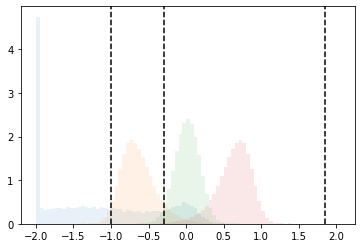

In [115]:
bins = np.arange(-2, 2.1, 0.05)

n_ddel, _, _ = plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)

n_del, _, _ = plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
n_norm, _, _ = plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
n_dup, _, _ = plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)

del_lb = bins[np.where((n_del[:-1]<n_ddel[:-1]) & (n_del[1:]>n_ddel[1:]))[0][0]+1]
norm_lb = bins[np.where((n_norm[:-1]<n_del[:-1]) & (n_norm[1:]>n_del[1:]))[0][0]+1]
norm_ub = bins[np.where((n_norm[:-1]>n_dup[:-1]) & (n_norm[1:]<n_dup[1:]))[0][-1]+1]
plt.axvline(norm_lb, color='black', linestyle='--')
plt.axvline(norm_ub, color='black', linestyle='--')
plt.axvline(del_lb, color='black', linestyle='--')

print(del_lb, norm_lb, norm_ub)

d = [d for d in deletions if d['family']==family_id and d['chrom']=='5' and d['start_pos']==47297558 and d['end_pos']==49624947][0]
print(d)

probes = del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])]
indices = np.isin(all_probes, probes)
print(len(probes))
                
for j in range(4):
    plt.axvline(np.median(probe_data[j, indices]))


plt.show()

In [292]:
num_dels = np.zeros((4, len(all_probes)), dtype=int)
sebat_num_dels = np.zeros((4, len(all_probes)), dtype=int)

is_child = np.zeros((4, len(all_probes)), dtype=bool)
is_child[2:, :] = True
is_parent = np.zeros((4, len(all_probes)), dtype=bool)
is_parent[:2, :] = True

sebat_is_child = np.zeros((4, len(all_probes)), dtype=bool)
sebat_is_child[2:, :] = True
sebat_is_parent = np.zeros((4, len(all_probes)), dtype=bool)
sebat_is_parent[:2, :] = True

med_probe_values = np.zeros((4, len(deletions)))
med_probe_values_hasdel = np.zeros((len(deletions),))
med_probe_values_nodel = np.zeros((len(deletions),))

has_del = np.zeros((4, len(deletions)), dtype=bool)

sebat_med_probe_values = np.zeros((4, len(sebat_deletions)))
sebat_has_del = np.zeros((4, len(sebat_deletions)), dtype=bool)
sebat_med_probe_values_hasdel = np.zeros((len(sebat_deletions),))
sebat_med_probe_values_nodel = np.zeros((len(sebat_deletions),))

num_probes = np.zeros((len(deletions),), dtype=int)
med_background = np.zeros((len(deletions),), dtype=float)

sebat_num_probes = np.zeros((len(sebat_deletions),), dtype=int)
sebat_med_background = np.zeros((len(sebat_deletions),), dtype=float)

for i, d in enumerate(deletions):
    probes = del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])]
    indices = np.isin(all_probes, probes)
    num_probes[i] = len(probes)
    
    if d['mother'] == ssc_ids[0] and d['father'] == ssc_ids[1]:
        if d['is_inherited']:
            if d['is_mat']:
                num_dels[0, indices] += 1
                has_del[0, i] = True
            elif d['is_pat']:
                num_dels[1, indices] += 1
                has_del[1, i] = True

        for child in d['trans']:
            if child_id_to_affected[child]=='2':
                num_dels[2, indices] += 1
                has_del[2, i] = True
            elif child_id_to_affected[child]=='1':
                num_dels[3, indices] += 1
                has_del[3, i] = True
                
        for j in range(4):
            med_probe_values[j, i] = np.median(probe_data[j, indices])
        med_probe_values_hasdel[i] = np.median(probe_data[np.ix_(has_del[:, i], indices)])
        med_probe_values_nodel[i] = np.median(probe_data[np.ix_(~has_del[:, i], indices)])
    
for i, d in enumerate(sebat_deletions):
    probes = del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])]
    indices = np.isin(all_probes, probes)
    sebat_num_probes[i] = len(probes)
    
    if d['mother'] == ssc_ids[0] and d['father'] == ssc_ids[1]:
        if d['is_mat']:
            sebat_num_dels[0, indices] += 1
            sebat_has_del[0, i] = True
        elif d['is_pat']:
            sebat_num_dels[1, indices] += 1
            sebat_has_del[1, i] = True

        for child in d['trans']:
            if child_id_to_affected[child]=='2':
                sebat_num_dels[2, indices] += 1
                sebat_has_del[2, i] = True
            elif child_id_to_affected[child]=='1':
                sebat_num_dels[3, indices] += 1
                sebat_has_del[3, i] = True
                
        for j in range(4):
            sebat_med_probe_values[j, i] = np.median(probe_data[j, indices])
        sebat_med_probe_values_hasdel[i] = np.median(probe_data[np.ix_(sebat_has_del[:, i], indices)])
        sebat_med_probe_values_nodel[i] = np.median(probe_data[np.ix_(~sebat_has_del[:, i], indices)])
        
        

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100 5894989
100 6967127
1.0
1.0
1.0
1.0


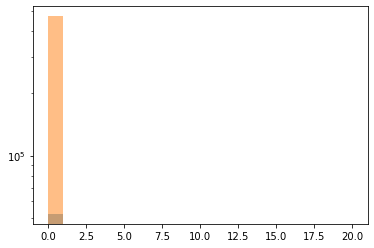

In [293]:
lengths = np.array([x['length'] for x in deletions])
sebat_lengths = np.array([x['length'] for x in sebat_deletions])

print(min(lengths), max(lengths))
print(min(sebat_lengths), max(sebat_lengths))

print(np.sum(num_probes==0)/len(num_probes))
print(np.sum(sebat_num_probes==0)/len(sebat_num_probes))
print(np.sum(num_probes[lengths>1000]==0)/np.sum(lengths>1000))
print(np.sum(sebat_num_probes[sebat_lengths>1000]==0)/np.sum(sebat_lengths>1000))
plt.hist(np.clip(num_probes, 0, 20), bins=np.arange(0, 21), alpha=0.5, log=True)
plt.hist(np.clip(sebat_num_probes, 0, 20), bins=np.arange(0, 21), alpha=0.5, log=True)
plt.show()

In [294]:
print(np.sum(num_dels, axis=1))
print(np.sum(has_del, axis=1))

[0 0 0 0]
[48 55 80 73]


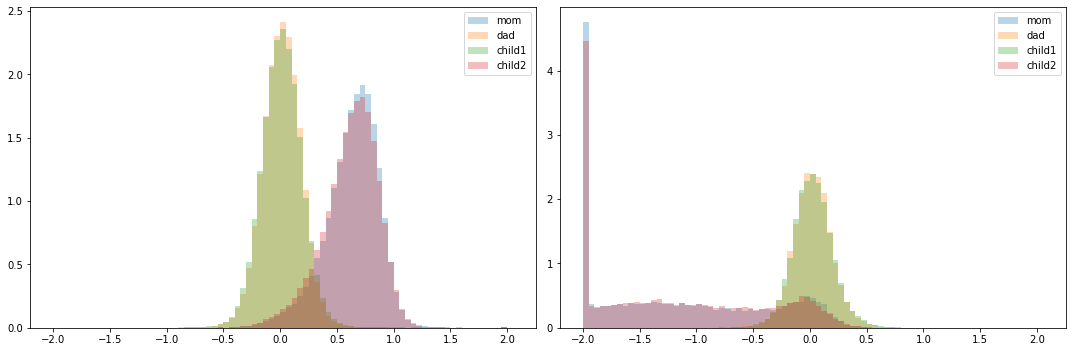

In [295]:
bins = np.arange(-2, 2.1, 0.05)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='mom', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='dad', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_child1_data)), -2, 2), label='child1', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_child2_data)), -2, 2), label='child2', alpha=0.3, bins=bins, density=True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='mom', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(y_dad_data)), -2, 2), label='dad', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(y_child1_data)), -2, 2), label='child1', alpha=0.3, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(y_child2_data)), -2, 2), label='child2', alpha=0.3, bins=bins, density=True)
plt.legend()
        
plt.tight_layout()
plt.show()

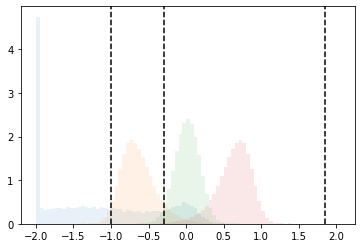

In [296]:
bins = np.arange(-2, 2.1, 0.05)

n_ddel, _, _ = plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)

n_del, _, _ = plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
n_norm, _, _ = plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
n_dup, _, _ = plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)

del_lb = bins[np.where((n_del[:-1]<n_ddel[:-1]) & (n_del[1:]>n_ddel[1:]))[0][0]+1]
norm_lb = bins[np.where((n_norm[:-1]<n_del[:-1]) & (n_norm[1:]>n_del[1:]))[0][0]+1]
norm_ub = bins[np.where((n_norm[:-1]>n_dup[:-1]) & (n_norm[1:]<n_dup[1:]))[0][-1]+1]
plt.axvline(norm_lb, color='black', linestyle='--')
plt.axvline(norm_ub, color='black', linestyle='--')
plt.axvline(del_lb, color='black', linestyle='--')



//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


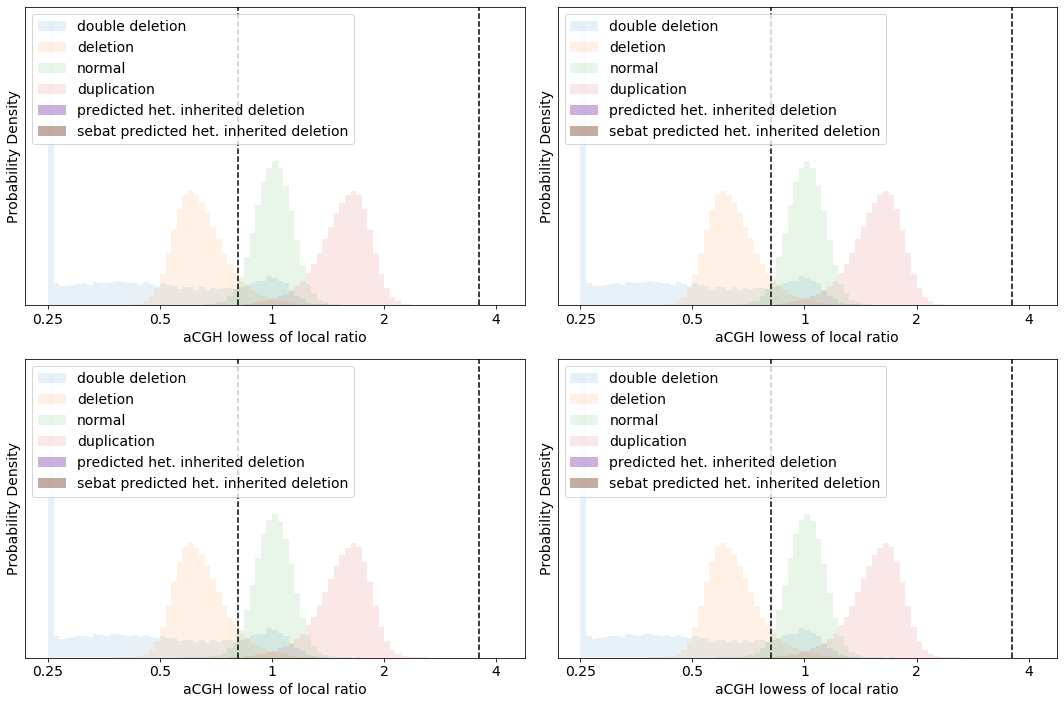

In [297]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

bins = np.arange(-2, 2.1, 0.05)

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)
    #plt.hist(np.clip(np.log2(probe_data[num_dels==0]), -2, 2), alpha=0.5, label='no del', bins=bins, density=True)
    #plt.hist(np.clip(np.log2(probe_data[(num_dels==1) & is_denovo]), -2, 2), label='predicted het. de novo deletion', alpha=0.5, bins=bins, density=True)
    plt.hist(np.clip(np.log2(probe_data[i, :][(num_dels[i, :]==1)]), -2, 2), label='predicted het. inherited deletion', alpha=0.5, bins=bins, density=True)
    plt.hist(np.clip(np.log2(probe_data[i, :][(sebat_num_dels[i, :]==1)]), -2, 2), label='sebat predicted het. inherited deletion', alpha=0.5, bins=bins, density=True)
    #plt.hist(np.clip(np.log2(probe_data[:2, :][(num_dels[:2, :]==1)]), -2, 2), label='predicted het. inherited deletion', alpha=0.5, bins=bins, density=True)
    plt.xticks([-2, -1, 0, 1, 2], ['0.25', '0.5', '1', '2', '4'])
    plt.legend(loc='upper left')
    plt.xlabel('aCGH lowess of local ratio')
    plt.yticks([], [])
    plt.ylabel('Probability Density')
    plt.axvline(norm_lb, color='black', linestyle='--')
    plt.axvline(norm_ub, color='black', linestyle='--')


plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (52204,) (44015,) 

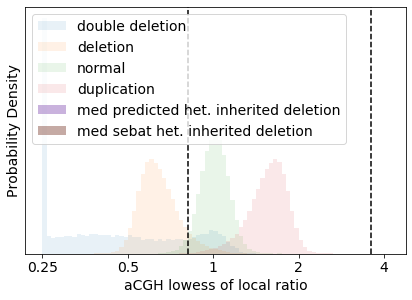

In [298]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

bins = np.arange(-2, 2.1, 0.05)

plt.figure(figsize=(15, 10))

a, b = 0, 0
c, d = 0, 0

a1, b1 = 0, 0
c1, d1 = 0, 0
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)
    #plt.hist(np.clip(np.log2(probe_data[num_dels==0]), -2, 2), alpha=0.5, label='no del', bins=bins, density=True)
    #plt.hist(np.clip(np.log2(probe_data[(num_dels==1) & is_denovo]), -2, 2), label='predicted het. de novo deletion', alpha=0.5, bins=bins, density=True)
    plt.hist(np.clip(np.log2(med_probe_values[i, has_del[i, :] & (num_probes>1)]), -2, 2), label='med predicted het. inherited deletion', alpha=0.5, bins=bins, density=True)
    plt.hist(np.clip(np.log2(sebat_med_probe_values[i, sebat_has_del[i, :] & (sebat_num_probes>1)]), -2, 2), label='med sebat het. inherited deletion', alpha=0.5, bins=bins, density=True)
    
    plt.xticks([-2, -1, 0, 1, 2], ['0.25', '0.5', '1', '2', '4'])
    plt.legend(loc='upper left')
    plt.xlabel('aCGH lowess of local ratio')
    plt.yticks([], [])
    plt.ylabel('Probability Density')
    plt.axvline(norm_lb, color='black', linestyle='--')
    plt.axvline(norm_ub, color='black', linestyle='--')
    
    a += np.sum(np.log2(med_probe_values[i, has_del[i, :] & (num_probes>0) & (lengths>1000)])<norm_lb)
    b += np.sum(has_del[i, :] & (num_probes>0) & (lengths>1000))
    c += np.sum(np.log2(sebat_med_probe_values[i, sebat_has_del[i, :] & (sebat_num_probes>0) & (sebat_lengths>1000)])<norm_lb)
    d += np.sum(sebat_has_del[i, :] & (sebat_num_probes>0) & (sebat_lengths>1000))
    
    a1 += np.sum(np.log2(med_probe_values[i, has_del[i, :] & (num_probes>0) & is_val & (lengths>1000)])<norm_lb)
    b1 += np.sum(has_del[i, :] & (num_probes>0) & is_val & (lengths>1000))
    c1 += np.sum(np.log2(sebat_med_probe_values[i, sebat_has_del[i, :] & (sebat_num_probes>0) & sebat_is_val & (sebat_lengths>1000)])<norm_lb)
    d1 += np.sum(sebat_has_del[i, :] & (sebat_num_probes>0) & sebat_is_val & (sebat_lengths>1000))
    print(np.sum(np.log2(med_probe_values[i, has_del[i, :] & (num_probes>1)])<norm_lb)/np.sum(has_del[i, :] & (num_probes>1)),
          np.sum(np.log2(sebat_med_probe_values[i, sebat_has_del[i, :] & (sebat_num_probes>1)])<norm_lb)/np.sum(sebat_has_del[i, :] & (sebat_num_probes>1)),
          np.sum(np.log2(med_probe_values[i, has_del[i, :] & is_val & (num_probes>1)])<norm_lb)/np.sum(has_del[i, :] & is_val & (num_probes>1)),
          np.sum(np.log2(sebat_med_probe_values[i, sebat_has_del[i, :] & sebat_is_val & (sebat_num_probes>1)])<norm_lb)/np.sum(sebat_has_del[i, :] & sebat_is_val & (sebat_num_probes>1)),)

print()
print(a/b, b)
print(c/d, d)
print(a1/b1, b1)
print(c1/d1, d1)
plt.tight_layout()
plt.show()

In [ ]:
print(len([x for x in deletions if len(x['trans'])==0])/len(deletions))
print(len([x for x in deletions if len(x['trans'])==1])/len(deletions))
print(len([x for x in deletions if len(x['trans'])==2])/len(deletions))

del-del 0.05813953488372093 0.0273972602739726
del-norm 0.5232558139534884 0.5308219178082192
del-dup 0.011627906976744186 0.017123287671232876
norm-del 0.011627906976744186 0.00684931506849315
norm-norm 0.19767441860465115 0.24315068493150685
norm-dup 0.1511627906976744 0.11986301369863013
dup-del 0.0 0.0
dup-norm 0.023255813953488372 0.010273972602739725
dup-dup 0.023255813953488372 0.04452054794520548

0.9069767441860465
0.8801369863013698
0.6200485474077957


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2

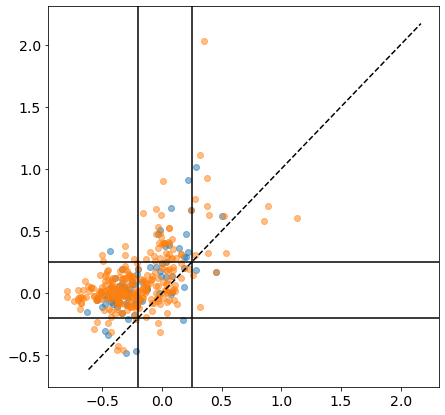

In [80]:
import scipy.stats as stats

plt.figure(figsize=(7, 7))
plt.scatter(np.log2(med_probe_values_hasdel), np.log2(med_probe_values_nodel), alpha=0.5)
plt.scatter(np.log2(sebat_med_probe_values_hasdel), np.log2(sebat_med_probe_values_nodel), alpha=0.5)
plt.plot(plt.ylim(), plt.ylim(), color='black', linestyle='--')
plt.axvline(norm_lb, color='black')
plt.axvline(norm_ub, color='black')
plt.axhline(norm_lb, color='black')
plt.axhline(norm_ub, color='black')

print('del-del', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)<norm_lb) & (np.log2(med_probe_values_nodel)<norm_lb))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)<norm_lb) & (np.log2(sebat_med_probe_values_nodel)<norm_lb))/np.sum(sebat_num_probes>0),
     )
print('del-norm', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)<norm_lb) & (np.log2(med_probe_values_nodel)>norm_lb) & (np.log2(med_probe_values_nodel)<norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)<norm_lb) & (np.log2(sebat_med_probe_values_nodel)>norm_lb) & (np.log2(sebat_med_probe_values_nodel)<norm_ub))/np.sum(sebat_num_probes>0),
     )
print('del-dup', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)<norm_lb) & (np.log2(med_probe_values_nodel)>norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)<norm_lb) & (np.log2(sebat_med_probe_values_nodel)>norm_ub))/np.sum(sebat_num_probes>0),
     )
print('norm-del', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_lb) & (np.log2(med_probe_values_hasdel)<norm_ub)& (np.log2(med_probe_values_nodel)<norm_lb))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_lb) & (np.log2(sebat_med_probe_values_hasdel)<norm_ub) & (np.log2(sebat_med_probe_values_nodel)<norm_lb))/np.sum(sebat_num_probes>0),
     )
print('norm-norm', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_lb) & (np.log2(med_probe_values_hasdel)<norm_ub) & (np.log2(med_probe_values_nodel)>norm_lb) & (np.log2(med_probe_values_nodel)<norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_lb) & (np.log2(sebat_med_probe_values_hasdel)<norm_ub) & (np.log2(sebat_med_probe_values_nodel)>norm_lb) & (np.log2(sebat_med_probe_values_nodel)<norm_ub))/np.sum(sebat_num_probes>0),
     )
print('norm-dup', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_lb) & (np.log2(med_probe_values_hasdel)<norm_ub) & (np.log2(med_probe_values_nodel)>norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_lb) & (np.log2(sebat_med_probe_values_hasdel)<norm_ub) & (np.log2(sebat_med_probe_values_nodel)>norm_ub))/np.sum(sebat_num_probes>0),
     )
print('dup-del', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_ub) & (np.log2(med_probe_values_nodel)<norm_lb))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_ub) & (np.log2(sebat_med_probe_values_nodel)<norm_lb))/np.sum(sebat_num_probes>0),
     )
print('dup-norm', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_ub) & (np.log2(med_probe_values_nodel)>norm_lb) & (np.log2(med_probe_values_nodel)<norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_ub) & (np.log2(sebat_med_probe_values_nodel)>norm_lb) & (np.log2(sebat_med_probe_values_nodel)<norm_ub))/np.sum(sebat_num_probes>0),
     )
print('dup-dup', 
      np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>norm_ub) & (np.log2(med_probe_values_nodel)>norm_ub))/np.sum(num_probes>0),
      np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>norm_ub) & (np.log2(sebat_med_probe_values_nodel)>norm_ub))/np.sum(sebat_num_probes>0),
     )

print()
print(np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)<np.log2(med_probe_values_nodel)))/np.sum(num_probes>0))
print(np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)<np.log2(sebat_med_probe_values_nodel)))/np.sum(sebat_num_probes>0))
print(stats.chi2_contingency([[np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)<np.log2(med_probe_values_nodel))),
                              np.sum((num_probes>0) & (np.log2(med_probe_values_hasdel)>np.log2(med_probe_values_nodel)))],
                             [np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)<np.log2(sebat_med_probe_values_nodel))),
                             np.sum((sebat_num_probes>0) & (np.log2(sebat_med_probe_values_hasdel)>np.log2(sebat_med_probe_values_nodel)))]])[1])
plt.show()

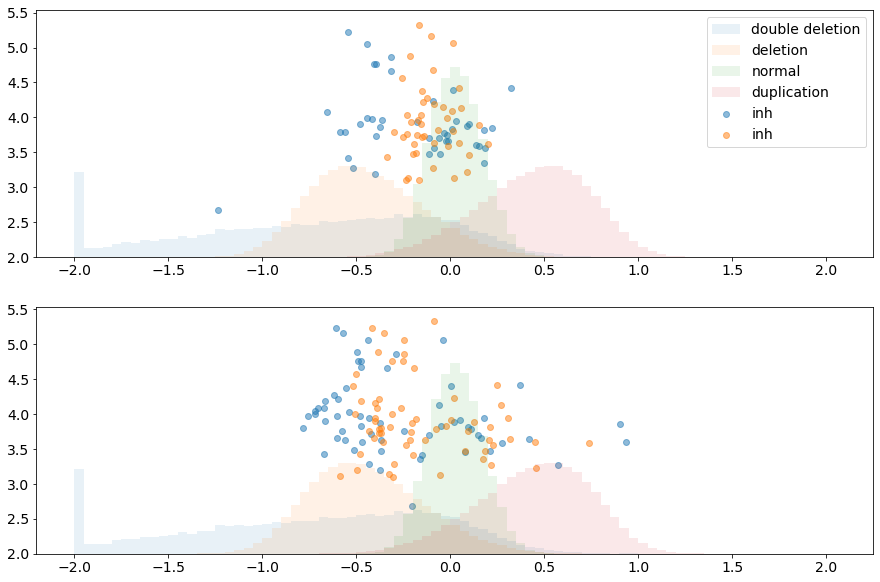

In [31]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
lengths = np.array([d['length'] for d in deletions])
plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)
plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)
 

for i in range(2):
    plt.scatter(np.clip(np.log2(med_probe_values[i, has_del[i, :]]), -2, 2), np.log10(lengths[has_del[i, :]])-2, alpha=0.5, label='inh')
plt.yticks(np.arange(plt.ylim()[0], plt.ylim()[1], 0.5), 2+np.arange(plt.ylim()[0], plt.ylim()[1], 0.5))
plt.legend()

plt.subplot(2, 1, 2)
lengths = np.array([d['length'] for d in deletions])
plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)
plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)
 

for i in range(2, 4):
    plt.scatter(np.clip(np.log2(med_probe_values[i, has_del[i, :]]), -2, 2), np.log10(lengths[has_del[i, :]])-2, alpha=0.5)
plt.yticks(np.arange(plt.ylim()[0], plt.ylim()[1], 0.5), 2+np.arange(plt.ylim()[0], plt.ylim()[1], 0.5))
plt.show()

In [ ]:
plt.scatter(lengths, num_probes)
plt.show()

In [ ]:
indices = has_del[0, :] & has_del[2, :]
plt.scatter(np.clip(np.log2(med_probe_values[0, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[2, indices]), -2, 2), alpha=0.5)

indices = has_del[0, :] & has_del[3, :]
plt.scatter(np.clip(np.log2(med_probe_values[0, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[3, indices]), -2, 2), alpha=0.5)

indices = has_del[1, :] & has_del[2, :]
plt.scatter(np.clip(np.log2(med_probe_values[1, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[2, indices]), -2, 2), alpha=0.5)

indices = has_del[1, :] & has_del[3, :]
plt.scatter(np.clip(np.log2(med_probe_values[1, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[3, indices]), -2, 2), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
indices = has_del[2, :] & has_del[3, :]
plt.scatter(np.clip(np.log2(med_probe_values[2, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[3, indices]), -2, 2), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
indices = has_del[2, :] & ~has_del[3, :]
plt.scatter(np.clip(np.log2(med_probe_values[2, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[3, indices]), -2, 2), alpha=0.5)
indices = ~has_del[2, :] & has_del[3, :]
plt.scatter(np.clip(np.log2(med_probe_values[3, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[2, indices]), -2, 2), alpha=0.5)

plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
indices = has_del[0, :] & has_del[1, :]
plt.scatter(np.clip(np.log2(med_probe_values[0, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[1, indices]), -2, 2), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
indices = has_del[0, :] & ~has_del[1, :]
plt.scatter(np.clip(np.log2(med_probe_values[0, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[1, indices]), -2, 2), alpha=0.5)
indices = ~has_del[0, :] & has_del[1, :]
plt.scatter(np.clip(np.log2(med_probe_values[1, indices]), -2, 2), 
            np.clip(np.log2(med_probe_values[0, indices]), -2, 2), alpha=0.5)

plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [ ]:

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(np.clip(np.log2(list(y_mom_data)), -2, 2), label='double deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(-np.clip(np.log2(list(x_mom_data)), -2, 2), label='deletion', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_dad_data)), -2, 2), label='normal', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(list(x_mom_data)), -2, 2), label='duplication', alpha=0.1, bins=bins, density=True)
    plt.hist(np.clip(np.log2(probe_data[i, :][(num_dels[i, :]==2)]), -2, 2), label='predicted hom. inherited deletion', alpha=0.5, bins=bins, density=True)
    plt.axvline(norm_lb, color='black', linestyle='--')
    plt.axvline(norm_ub, color='black', linestyle='--')
    plt.xticks([-2, -1, 0, 1, 2], ['0.25', '0.5', '1', '2', '4'])
    plt.legend()
    plt.xlabel('aCGH lowess of local ratio')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
indices = (num_dels[2, :] ==1) & (num_dels[3, :]==1)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=1, C2=1')
indices = (num_dels[2, :] ==2) & (num_dels[3, :]==2)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=2, C2=2')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.subplot(2, 3, 2)
indices = (num_dels[2, :]==1) & (num_dels[3, :]==0)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=1, C2=0')
indices = (num_dels[2, :]==2) & (num_dels[3, :]==1)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=2, C2=1')
indices = (num_dels[2, :]==2) & (num_dels[3, :]==0)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=2, C2=0')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.subplot(2, 3, 3)
indices = (num_dels[2, :]==0) & (num_dels[3, :]==1)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=0, C2=1')
indices = (num_dels[2, :]==1) & (num_dels[3, :]==2)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=1, C2=2')
indices = (num_dels[2, :]==0) & (num_dels[3, :]==2)
plt.scatter(probe_data[2, indices], probe_data[3, indices], alpha=0.5, label='C1=0, C2=2')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.subplot(2, 3, 4)
indices = (num_dels[0, :] ==1) & (num_dels[1, :]==1)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=1, C2=1')
indices = (num_dels[0, :] ==2) & (num_dels[1, :]==2)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=2, C2=2')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.subplot(2, 3, 5)
indices = (num_dels[0, :]==1) & (num_dels[1, :]==0)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=1, C2=0')
indices = (num_dels[0, :]==2) & (num_dels[1, :]==1)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=2, C2=1')
indices = (num_dels[0, :]==2) & (num_dels[1, :]==0)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=2, C2=0')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.subplot(2, 3, 6)
indices = (num_dels[0, :]==0) & (num_dels[1, :]==1)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=0, C2=1')
indices = (num_dels[0, :]==1) & (num_dels[1, :]==2)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=1, C2=2')
indices = (num_dels[0, :]==0) & (num_dels[1, :]==2)
plt.scatter(probe_data[0, indices], probe_data[1, indices], alpha=0.5, label='C1=0, C2=2')
plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
indices = (num_dels[0, :]==0) & (num_dels[1, :]==1) & (num_dels[2, :]==1)
plt.scatter(np.log2(probe_data[2, indices])-np.log2(probe_data[0, indices]),
           np.log2(probe_data[2, indices])-np.log2(probe_data[1, indices]), alpha=0.5, marker='.')
indices = (num_dels[0, :]==1) & (num_dels[1, :]==0) & (num_dels[2, :]==1)
plt.scatter(np.log2(probe_data[2, indices])-np.log2(probe_data[1, indices]),
           np.log2(probe_data[2, indices])-np.log2(probe_data[0, indices]), alpha=0.5, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 2, sharex=ax, sharey=ax)
indices = (num_dels[0, :]==0) & (num_dels[1, :]==1) & (num_dels[3, :]==1)
plt.scatter(np.log2(probe_data[3, indices])-np.log2(probe_data[0, indices]),
           np.log2(probe_data[3, indices])-np.log2(probe_data[1, indices]), alpha=0.5, marker='.')
indices = (num_dels[0, :]==1) & (num_dels[1, :]==0) & (num_dels[3, :]==1)
plt.scatter(np.log2(probe_data[3, indices])-np.log2(probe_data[1, indices]),
           np.log2(probe_data[3, indices])-np.log2(probe_data[0, indices]), alpha=0.5, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 3, sharex=ax, sharey=ax)
indices = (num_dels[0, :]==0) & (num_dels[1, :]==1) & (num_dels[2, :]==0)
plt.scatter(np.log2(probe_data[2, indices])-np.log2(probe_data[0, indices]),
           np.log2(probe_data[2, indices])-np.log2(probe_data[1, indices]), alpha=0.5, marker='.')
indices = (num_dels[0, :]==1) & (num_dels[1, :]==0) & (num_dels[2, :]==0)
plt.scatter(np.log2(probe_data[2, indices])-np.log2(probe_data[1, indices]),
           np.log2(probe_data[2, indices])-np.log2(probe_data[0, indices]), alpha=0.5, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 4, sharex=ax, sharey=ax)
indices = (num_dels[0, :]==0) & (num_dels[1, :]==1) & (num_dels[3, :]==0)
plt.scatter(np.log2(probe_data[3, indices])-np.log2(probe_data[0, indices]),
           np.log2(probe_data[3, indices])-np.log2(probe_data[1, indices]), alpha=0.5, marker='.')
indices = (num_dels[0, :]==1) & (num_dels[1, :]==0) & (num_dels[3, :]==0)
plt.scatter(np.log2(probe_data[3, indices])-np.log2(probe_data[1, indices]),
           np.log2(probe_data[3, indices])-np.log2(probe_data[0, indices]), alpha=0.5, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
indices = ~has_del[0, :] & has_del[1, :] & has_del[2, :]
plt.scatter(np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[0, indices]),
           np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[1, indices]), alpha=0.5)
indices = has_del[0, :] & ~has_del[1, :] & has_del[2, :]
plt.scatter(np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[1, indices]),
           np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[0, indices]), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 2, sharex=ax, sharey=ax)
indices = ~has_del[0, :] & has_del[1, :] & has_del[3, :]
plt.scatter(np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[0, indices]),
           np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[1, indices]), alpha=0.5)
indices = has_del[0, :] & ~has_del[1, :] & has_del[3, :]
plt.scatter(np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[1, indices]),
           np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[0, indices]), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 3, sharex=ax, sharey=ax)
indices = ~has_del[0, :] & has_del[1, :] & ~has_del[2, :]
plt.scatter(np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[0, indices]),
           np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[1, indices]), alpha=0.5)
indices = has_del[0, :] & ~has_del[1, :] & ~has_del[2, :]
plt.scatter(np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[1, indices]),
           np.log2(med_probe_values[2, indices])-np.log2(med_probe_values[0, indices]), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')

plt.subplot(2, 2, 4, sharex=ax, sharey=ax)
indices = ~has_del[0, :] & has_del[1, :] & ~has_del[3, :]
plt.scatter(np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[0, indices]),
           np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[1, indices]), alpha=0.5)
indices = has_del[0, :] & ~has_del[1, :] & ~has_del[3, :]
plt.scatter(np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[1, indices]),
           np.log2(med_probe_values[3, indices])-np.log2(med_probe_values[0, indices]), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('log2(child/no del parent)')
plt.ylabel('log2(child/del parent)')
plt.show()

In [ ]:
all_pos = np.array([probe_to_pos[x] for x in all_probes])

In [ ]:
print(len(probe_index_to_background_data))

In [ ]:
del_index = 3

plt.figure(figsize=(15, 10))
d = deletions[del_index]
probes = del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])]
poss = np.array([probe_to_pos[x] for x in probes])
indices = np.isin(all_probes, probes)

print(probe_data.shape, np.sum(indices), num_dels.shape)
print(num_dels[:, indices])

plt.subplot(2, 1, 1)
plt.axhline(0, color='black')
for i in range(len(members)):
    p = plt.plot(all_pos[indices], np.log2(probe_data[i, indices]), linestyle='', marker='.')
    #plt.plot(poss[num_dels[i, indices]==0], probe_data[i, indices][num_dels[i, indices]==0], linestyle='-', color=p[0].get_color())
    #plt.plot(poss[num_dels[i, indices]==1], probe_data[i, indices][num_dels[i, indices]==1], linestyle='--', color=p[0].get_color())
    #plt.plot(poss[num_dels[i, indices]==2], probe_data[i, indices][num_dels[i, indices]==2], linestyle='-.', color=p[0].get_color())
    plt.axhline(np.log2(np.median(probe_data[i, indices])), color=p[0].get_color(), alpha=0.5, label=members[i])
    
xs, ys = [], []
for index in np.where(indices)[0]:
    background = probe_index_to_background_data[index]
    xs.extend([all_pos[index]]*len(background))
    ys.extend(np.log10(background))
plt.plot(xs, ys, marker='.', linestyle='', color='grey')
plt.axhline(np.median(ys), color='grey', alpha=0.5)
  
plt.yticks(np.arange(-1, 2), [2.0**x for x in np.arange(-2, 3)])
plt.legend()
#plt.ylim([0, None])
plt.xlim([d['start_pos'], d['end_pos']])

plt.subplot(2, 1, 2)

with open('../../DATA/ssc.hg38/genotypes/pilot/samples.json', 'r') as f:
    sample_ids = json.load(f)
sample_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])
sample_indices = [sample_to_index[x] for x in ssc_ids]
print(sample_indices)

gen_data = []
for f in listdir('../../DATA/ssc.hg38/genotypes/pilot'):
    if f.startswith('chr.%s.' % d['chrom']) and f.endswith('.gen.coordinates.npy'):
        coords = np.load('../../DATA/ssc.hg38/genotypes/pilot/%s' % f)
        if len(coords)>0:
            indices = (coords[:, 1]>=d['start_pos']) & (coords[:, 1]<=d['end_pos'])
            if np.sum(indices)>0:
                gen_data.append(sparse.load_npz('../../DATA/ssc.hg38/genotypes/pilot/%s.npz' % f[:-16])[sample_indices, :][:, indices].A)
gen_data = np.hstack(gen_data)
plt.imshow(gen_data, aspect='auto', vmin=-1, vmax=2)

plt.tight_layout()
plt.show()

In [ ]:
nodel_data = np.array(list(x_dad_data))
del_data = 1/np.array(list(x_mom_data))
doubledel_data = np.array(list(y_mom_data))

In [ ]:
med_probe = np.zeros((len(members), len(deletions)))
num_dels = np.zeros((len(members), len(deletions)), dtype=bool)
ks_pvalues = np.zeros((len(members), len(deletions), 3))

for i, d in enumerate(deletions):
    probes = del_to_probes[(d['chrom'], d['start_pos'], d['end_pos'])]
    indices = np.isin(all_probes, probes)
    
    if np.sum(indices) > 0:
        med_probe[:, i] = np.median(probe_data[:, indices], axis=1)
        for j in range(4):
            ks_pvalues[j, i, 0] = scipy.stats.ks_2samp(probe_data[j, indices], nodel_data)[1]
            ks_pvalues[j, i, 1] = scipy.stats.ks_2samp(probe_data[j, indices], del_data)[1]
            ks_pvalues[j, i, 2] = scipy.stats.ks_2samp(probe_data[j, indices], doubledel_data)[1]
    else:
        med_probe[:, i] = np.nan
        ks_pvalues[:, i, :] = np.nan
        
    
    if not d['is_denovo']:
        if d['is_mat']:
            num_dels[0, i] += 1
        if d['is_pat']:
            num_dels[1, i] += 1
        for child in d['trans']:
            num_dels[members.index(child.split('.')[1]), i] += 1


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(np.clip(-np.log10(ks_pvalues[:, :, 0][num_dels==0]), None, 10), alpha=0.5)
plt.hist(np.clip(-np.log10(ks_pvalues[:, :, 0][num_dels==0]), None, 10))
plt.hist(np.clip(-np.log10(ks_pvalues[:, :, 0][num_dels==0]), None, 10))

plt.subplot(1, 3, 2)
plt.hist(np.clip(-np.log10(ks_pvalues[:, :, 0][num_dels==1]), None, 10))

plt.subplot(1, 3, 3)
plt.hist(np.clip(-np.log10(ks_pvalues[:, :, 0][num_dels==2]), None, 10))

plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(np.clip(-np.log10(ks_pvalues[:, :, 0]), None, 10),
            np.clip(-np.log10(ks_pvalues[:, :, 2]), None, 10))

In [ ]:
plt.hist(np.clip(np.log2(med_probe[num_dels==0]), -2, 2), bins=np.arange(-2, 2.1, 0.1), 
         alpha=0.5, density=True)
plt.hist(np.clip(np.log2(med_probe[num_dels==1]), -2, 2), bins=np.arange(-2, 2.1, 0.1), 
         alpha=0.5, density=True)
plt.hist(np.clip(np.log2(med_probe[num_dels==2]), -2, 2), bins=np.arange(-2, 2.1, 0.1), 
         alpha=0.5, density=True)

plt.show()